In [1]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.models import *
from tensorflow.keras.layers import *  
from tensorflow.keras.callbacks import *
import tensorflow_addons as tfa
from tqdm import tqdm
import time
import random
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow_probability import distributions as tfd
import seaborn as sns
from keras.utils.np_utils import to_categorical

In [2]:
## season 2 dataframes 
train_x_2 = pd.read_csv('train_x_df.csv')
train_y_2 = pd.read_csv('train_y_df.csv') 
test_x_2 = pd.read_csv('test_x_df.csv') 
submission = pd.read_csv('sample_submission.csv') 

train_x_2.shape, train_y_2.shape, test_x_2.shape, submission.shape

((10572180, 12), (919320, 12), (738300, 12), (535, 3))

In [3]:
def df2d_to_array3d(df_2d):
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d


x_train = df2d_to_array3d(train_x_2) 
y_train = df2d_to_array3d(train_y_2) 
x_test = df2d_to_array3d(test_x_2) 

x_train.shape, y_train.shape, x_test.shape


((7661, 1380, 10), (7661, 120, 10), (535, 1380, 10))

In [4]:
def plot_series(x_series, y_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'actual_series') 
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()

def plot_predicted_series(x_series, y_predicted):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_predicted)),
             y_predicted, label = 'predicted_series') 
    #plt.axhline(1, c = 'red')
    plt.legend()


In [5]:
full_df = np.concatenate([x_train, y_train], axis = 1) 
full_df.shape

(7661, 1500, 10)

In [6]:
price_data = full_df[:,:,[1,2,3,4]] 
price_data.shape

(7661, 1500, 4)

In [8]:
volume_data = full_df[:,:,[5,6,7,8,9]]
volume_data.shape

(7661, 1500, 5)

# Preprocess Data

In [10]:
K = 120 
N = 30
seq_len = 1500 
features_price = 4 
features_volume = 5 
X_price = np.zeros(((seq_len-N-K)*price_data.shape[0], N, features_price))
X_volume = np.zeros(((seq_len-N-K)*price_data.shape[0], N, features_volume))
Y = np.zeros(((seq_len-N-K)*price_data.shape[0]))

cnt = 0 
for j in tqdm(range(price_data.shape[0]), position = 0, leave = True): 
    i = 0
    while i+N+K < 1500: 
        X_price[cnt,:,:] = price_data[j, i:i+N, :] 
        X_volume[cnt,:,:] = volume_data[j, i:i+N, :] 
        Y[cnt] = price_data[j, i+N+K, 0] 
        i += 1   
        cnt += 1 
        

X_price.shape, X_volume.shape, Y.shape


100%|██████████| 7661/7661 [00:50<00:00, 152.54it/s]


((10342350, 30, 4), (10342350, 30, 5), (10342350,))

# Define Model

In [11]:
class Time2Vector(Layer):
    def __init__(self, seq_len, **kwargs):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

    def build(self, input_shape):
        '''Initialize weights and biases with shape (batch, seq_len)'''
        self.weights_linear = self.add_weight(name='weight_linear',
                                              shape=(int(self.seq_len),),
                                              initializer='glorot_uniform',
                                              trainable=True)
    
        self.bias_linear = self.add_weight(name='bias_linear',
                                           shape=(int(self.seq_len),),
                                           initializer='glorot_uniform',
                                           trainable=True)
    
        self.weights_periodic = self.add_weight(name='weight_periodic',
                                                shape=(int(self.seq_len),),
                                                initializer='glorot_uniform',
                                                trainable=True)

        self.bias_periodic = self.add_weight(name='bias_periodic',
                                             shape=(int(self.seq_len),),
                                             initializer='glorot_uniform',
                                             trainable=True)

    def call(self, x):
        '''Calculate linear and periodic time features'''
        x = tf.math.reduce_mean(x[:,:,:], axis=-1) 
        time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
        time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
        time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
        time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
        return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
    def get_config(self): # Needed for saving and loading model with custom layer
        config = super().get_config().copy()
        config.update({'seq_len': self.seq_len})
        return config


In [14]:
def gru_block(inputs): 
    time_embedding = Time2Vector(N) 
    bn = BatchNormalization()(inputs) 
    x = time_embedding(bn) 
    x = Concatenate()([bn, x]) 
    x = GRU(128, return_sequences = True)(x) 
    x = Dropout(0.25)(x) 
    x = GRU(128, return_sequences = True)(x) 
    x = Dropout(0.25)(x) 
    x = GRU(128, return_sequences = False)(x) 
    x = Dropout(0.2)(x) 
    x = Dense(64, activation = 'relu', kernel_initializer = 'he_normal')(x) 
    x = BatchNormalization()(x) 
    return x 

def build_model(): 
    price_inputs = Input((N, features_price)) 
    gru_price = gru_block(price_inputs) 
    
    volume_inputs = Input((N, features_volume))
    gru_volume = gru_block(volume_inputs) 
    
    x = Concatenate()([gru_price, gru_volume])
    x = Dense(64, activation = 'relu', kernel_initializer = 'he_normal')(x) 
    x = BatchNormalization()(x) 
    x = Dense(32, activation = 'relu', kernel_initializer = 'he_normal')(x) 
    x = BatchNormalization()(x) 
    x = Dense(1, activation = 'relu')(x) 
    model = Model(inputs=[price_inputs,volume_inputs],outputs=x) 
    model.compile(loss='mape',optimizer='adam',metrics=['mse','mae','mape']) 
    return model 

In [15]:
model = build_model() 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 30, 4)        16          input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 30, 5)        20          input_4[0][0]                    
______________________________________________________________________________________________

# Train

In [16]:
model_path = 'GRU_price_volume_epoch_{epoch:03d}_val_{val_loss:.3f}.h5'
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5)
checkpoint = ModelCheckpoint(filepath = model_path, monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10) 


history = model.fit([X_price, X_volume], 
                     Y, 
                     batch_size = 128, 
                     epochs = 50, 
                     callbacks = [learning_rate_reduction, checkpoint], 
                     validation_split = 0.1)


Epoch 1/50
 7361/72720 [==>...........................] - ETA: 27:49 - loss: 6.0998 - mse: 0.0334 - mae: 0.0612 - mape: 6.0998

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 2029s 27ms/step - loss: 1.9617 - mse: 0.0054 - mae: 0.0197 - mape: 1.9617 - val_loss: 1.0372 - val_mse: 4.1057e-04 - val_mae: 0.0105 - val_mape: 1.0372

Epoch 00001: val_loss improved from inf to 1.03721, saving model to GRU_price_volume_epoch_001_val_1.037.h5
Epoch 2/50
72720/72720 [==============================] - 1923s 26ms/step - loss: 1.1145 - mse: 3.6485e-04 - mae: 0.0112 - mape: 1.1145 - val_loss: 1.0077 - val_mse: 3.7331e-04 - val_mae: 0.0101 - val_mape: 1.0077

Epoch 00002: val_loss improved from 1.03721 to 1.00769, saving model to GRU_price_volume_epoch_002_val_1.008.h5
Epoch 3/50
37694/72720 [==============>...............] - ETA: 14:39 - loss: 1.0897 - mse: 3.3740e-04 - mae: 0.0109 - mape: 1.0897

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



53364/72720 [=====================>........] - ETA: 8:07 - loss: 1.0902 - mse: 3.3805e-04 - mae: 0.0109 - mape: 1.0902

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



68809/72720 [===========================>..] - ETA: 1:38 - loss: 1.0902 - mse: 3.3764e-04 - mae: 0.0109 - mape: 1.0902

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11560/72720 [===>..........................] - ETA: 26:04 - loss: 1.0740 - mse: 3.1986e-04 - mae: 0.0108 - mape: 1.0740

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



26818/72720 [==========>...................] - ETA: 19:25 - loss: 1.0713 - mse: 3.1666e-04 - mae: 0.0107 - mape: 1.0713

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



43078/72720 [================>.............] - ETA: 12:27 - loss: 1.0714 - mse: 3.1526e-04 - mae: 0.0107 - mape: 1.0714

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



67342/72720 [==========================>...] - ETA: 2:15 - loss: 1.0719 - mse: 3.1391e-04 - mae: 0.0107 - mape: 1.0719

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



10379/72720 [===>..........................] - ETA: 26:19 - loss: 1.0701 - mse: 3.1736e-04 - mae: 0.0107 - mape: 1.0701

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



25841/72720 [=========>....................] - ETA: 19:43 - loss: 1.0705 - mse: 3.1374e-04 - mae: 0.0107 - mape: 1.0705

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



41420/72720 [================>.............] - ETA: 13:05 - loss: 1.0706 - mse: 3.1167e-04 - mae: 0.0107 - mape: 1.0706

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



56286/72720 [======================>.......] - ETA: 6:55 - loss: 1.0697 - mse: 3.1024e-04 - mae: 0.0107 - mape: 1.0697

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 1918s 26ms/step - loss: 1.0687 - mse: 3.0912e-04 - mae: 0.0107 - mape: 1.0687 - val_loss: 1.6953 - val_mse: 0.2343 - val_mae: 0.0215 - val_mape: 1.6953

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00005: val_loss did not improve from 1.00769
Epoch 6/50
39932/72720 [===============>..............] - ETA: 13:46 - loss: 1.0352 - mse: 2.8827e-04 - mae: 0.0104 - mape: 1.0352

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



55826/72720 [======================>.......] - ETA: 7:05 - loss: 1.0343 - mse: 2.8718e-04 - mae: 0.0104 - mape: 1.0343

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 1904s 26ms/step - loss: 1.0335 - mse: 2.8628e-04 - mae: 0.0103 - mape: 1.0335 - val_loss: 1.0816 - val_mse: 0.0025 - val_mae: 0.0112 - val_mape: 1.0816

Epoch 00006: val_loss did not improve from 1.00769
Epoch 7/50
 7071/72720 [=>............................] - ETA: 27:54 - loss: 1.0254 - mse: 2.7849e-04 - mae: 0.0103 - mape: 1.0254

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



22345/72720 [========>.....................] - ETA: 21:12 - loss: 1.0250 - mse: 2.7866e-04 - mae: 0.0103 - mape: 1.0250

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



38181/72720 [==============>...............] - ETA: 14:25 - loss: 1.0253 - mse: 2.7921e-04 - mae: 0.0103 - mape: 1.0253

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



54672/72720 [=====================>........] - ETA: 7:30 - loss: 1.0252 - mse: 2.7934e-04 - mae: 0.0103 - mape: 1.0252

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



71068/72720 [============================>.] - ETA: 41s - loss: 1.0250 - mse: 2.7939e-04 - mae: 0.0103 - mape: 1.0250

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



17494/72720 [======>.......................] - ETA: 22:59 - loss: 1.0210 - mse: 2.8126e-04 - mae: 0.0102 - mape: 1.0210

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



33315/72720 [============>.................] - ETA: 16:27 - loss: 1.0221 - mse: 2.8135e-04 - mae: 0.0102 - mape: 1.0221

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



49398/72720 [===================>..........] - ETA: 9:44 - loss: 1.0223 - mse: 2.8107e-04 - mae: 0.0102 - mape: 1.0223

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



66004/72720 [==========================>...] - ETA: 2:47 - loss: 1.0223 - mse: 2.8070e-04 - mae: 0.0102 - mape: 1.0223

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 9810/72720 [===>..........................] - ETA: 25:55 - loss: 1.0213 - mse: 2.7788e-04 - mae: 0.0102 - mape: 1.0213

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



28819/72720 [==========>...................] - ETA: 17:59 - loss: 1.0205 - mse: 2.7684e-04 - mae: 0.0102 - mape: 1.0205

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



44043/72720 [=================>............] - ETA: 11:51 - loss: 1.0202 - mse: 2.7661e-04 - mae: 0.0102 - mape: 1.0202

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 1890s 26ms/step - loss: 1.0198 - mse: 2.7636e-04 - mae: 0.0102 - mape: 1.0198 - val_loss: 1.0998 - val_mse: 0.0016 - val_mae: 0.0110 - val_mape: 1.0998

Epoch 00009: val_loss did not improve from 0.99044
Epoch 10/50
29090/72720 [===========>..................] - ETA: 17:57 - loss: 1.0168 - mse: 2.7378e-04 - mae: 0.0102 - mape: 1.0168

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



45370/72720 [=================>............] - ETA: 11:13 - loss: 1.0167 - mse: 2.7404e-04 - mae: 0.0102 - mape: 1.0167

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 1869s 26ms/step - loss: 1.0167 - mse: 2.7426e-04 - mae: 0.0102 - mape: 1.0167 - val_loss: 1.1750 - val_mse: 0.0031 - val_mae: 0.0119 - val_mape: 1.1750

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00010: val_loss did not improve from 0.99044
Epoch 11/50
72720/72720 [==============================] - 1871s 26ms/step - loss: 1.0064 - mse: 2.6867e-04 - mae: 0.0101 - mape: 1.0064 - val_loss: 1.0752 - val_mse: 0.0024 - val_mae: 0.0112 - val_mape: 1.0752

Epoch 00011: val_loss did not improve from 0.99044
Epoch 12/50
51695/72720 [====================>.........] - ETA: 8:33 - loss: 1.0044 - mse: 2.6806e-04 - mae: 0.0101 - mape: 1.0044

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



67576/72720 [==========================>...] - ETA: 2:06 - loss: 1.0043 - mse: 2.6815e-04 - mae: 0.0101 - mape: 1.0043

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11185/72720 [===>..........................] - ETA: 25:00 - loss: 1.0020 - mse: 2.6641e-04 - mae: 0.0100 - mape: 1.0020

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



27798/72720 [==========>...................] - ETA: 18:10 - loss: 1.0035 - mse: 2.6752e-04 - mae: 0.0100 - mape: 1.0035

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



45213/72720 [=================>............] - ETA: 11:06 - loss: 1.0034 - mse: 2.6744e-04 - mae: 0.0100 - mape: 1.0034

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



64074/72720 [=========================>....] - ETA: 3:29 - loss: 1.0032 - mse: 2.6738e-04 - mae: 0.0100 - mape: 1.0032

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 8601/72720 [==>...........................] - ETA: 25:54 - loss: 0.9997 - mse: 2.6489e-04 - mae: 0.0100 - mape: 0.9997

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



26437/72720 [=========>....................] - ETA: 18:38 - loss: 0.9980 - mse: 2.6420e-04 - mae: 0.0100 - mape: 0.9980

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



43650/72720 [=================>............] - ETA: 11:43 - loss: 0.9980 - mse: 2.6435e-04 - mae: 0.0100 - mape: 0.9980

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



70350/72720 [============================>.] - ETA: 57s - loss: 0.9980 - mse: 2.6440e-04 - mae: 0.0100 - mape: 0.9980

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



15263/72720 [=====>........................] - ETA: 23:18 - loss: 0.9985 - mse: 2.6374e-04 - mae: 0.0100 - mape: 0.9985

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



32986/72720 [============>.................] - ETA: 16:05 - loss: 0.9977 - mse: 2.6370e-04 - mae: 0.0100 - mape: 0.9977

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



51278/72720 [====================>.........] - ETA: 8:38 - loss: 0.9975 - mse: 2.6381e-04 - mae: 0.0100 - mape: 0.9975

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



68357/72720 [===========================>..] - ETA: 1:45 - loss: 0.9973 - mse: 2.6378e-04 - mae: 0.0100 - mape: 0.9973

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19343/72720 [======>.......................] - ETA: 21:08 - loss: 0.9962 - mse: 2.6368e-04 - mae: 0.0100 - mape: 0.9962

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



38788/72720 [===============>..............] - ETA: 13:26 - loss: 0.9962 - mse: 2.6366e-04 - mae: 0.0100 - mape: 0.9962

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



57182/72720 [======================>.......] - ETA: 6:09 - loss: 0.9961 - mse: 2.6364e-04 - mae: 0.0100 - mape: 0.9961

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 1815s 25ms/step - loss: 0.9960 - mse: 2.6360e-04 - mae: 0.0100 - mape: 0.9960 - val_loss: 1.1894 - val_mse: 0.0153 - val_mae: 0.0131 - val_mape: 1.1894

Epoch 00016: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00016: val_loss did not improve from 0.99044
Epoch 17/50
 3588/72720 [>.............................] - ETA: 27:02 - loss: 0.9898 - mse: 2.6140e-04 - mae: 0.0099 - mape: 0.9898

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



29253/72720 [===========>..................] - ETA: 17:19 - loss: 0.9915 - mse: 2.6162e-04 - mae: 0.0099 - mape: 0.9915

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



48566/72720 [===================>..........] - ETA: 9:35 - loss: 0.9921 - mse: 2.6180e-04 - mae: 0.0099 - mape: 0.9921

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



67015/72720 [==========================>...] - ETA: 2:16 - loss: 0.9923 - mse: 2.6189e-04 - mae: 0.0099 - mape: 0.9923

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



13131/72720 [====>.........................] - ETA: 23:34 - loss: 0.9901 - mse: 2.5851e-04 - mae: 0.0099 - mape: 0.9901

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



38895/72720 [===============>..............] - ETA: 13:25 - loss: 0.9921 - mse: 2.6058e-04 - mae: 0.0099 - mape: 0.9921

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



57077/72720 [======================>.......] - ETA: 6:13 - loss: 0.9922 - mse: 2.6103e-04 - mae: 0.0099 - mape: 0.9922

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 1814s 25ms/step - loss: 0.9922 - mse: 2.6114e-04 - mae: 0.0099 - mape: 0.9922 - val_loss: 1.8830 - val_mse: 0.2719 - val_mae: 0.0238 - val_mape: 1.8830

Epoch 00018: val_loss did not improve from 0.99044
Epoch 19/50
 2265/72720 [..............................] - ETA: 28:17 - loss: 0.9857 - mse: 2.5933e-04 - mae: 0.0099 - mape: 0.9857

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



19453/72720 [=======>......................] - ETA: 21:47 - loss: 0.9906 - mse: 2.6139e-04 - mae: 0.0099 - mape: 0.9906

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 1840s 25ms/step - loss: 0.9914 - mse: 2.6161e-04 - mae: 0.0099 - mape: 0.9914 - val_loss: 2.4002 - val_mse: 0.6475 - val_mae: 0.0318 - val_mape: 2.4002

Epoch 00019: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00019: val_loss did not improve from 0.99044
Epoch 20/50
52512/72720 [====================>.........] - ETA: 8:08 - loss: 0.9904 - mse: 2.6089e-04 - mae: 0.0099 - mape: 0.9904

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



69538/72720 [===========================>..] - ETA: 1:16 - loss: 0.9905 - mse: 2.6095e-04 - mae: 0.0099 - mape: 0.9905

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



14642/72720 [=====>........................] - ETA: 23:18 - loss: 0.9902 - mse: 2.6001e-04 - mae: 0.0099 - mape: 0.9902

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



31298/72720 [===========>..................] - ETA: 16:54 - loss: 0.9901 - mse: 2.5997e-04 - mae: 0.0099 - mape: 0.9901

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



46785/72720 [==================>...........] - ETA: 10:39 - loss: 0.9901 - mse: 2.6010e-04 - mae: 0.0099 - mape: 0.9901

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



60506/72720 [=======================>......] - ETA: 5:07 - loss: 0.9901 - mse: 2.6026e-04 - mae: 0.0099 - mape: 0.9901

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



72720/72720 [==============================] - 1954s 27ms/step - loss: 0.9901 - mse: 2.6041e-04 - mae: 0.0099 - mape: 0.9901 - val_loss: 3.0588 - val_mse: 1.2923 - val_mae: 0.0417 - val_mape: 3.0588

Epoch 00021: val_loss did not improve from 0.99044
Epoch 22/50
  620/72720 [..............................] - ETA: 32:57 - loss: 0.9910 - mse: 2.6066e-04 - mae: 0.0099 - mape: 0.9910

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



16847/72720 [=====>........................] - ETA: 23:27 - loss: 0.9915 - mse: 2.6099e-04 - mae: 0.0099 - mape: 0.9915

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



30035/72720 [===========>..................] - ETA: 17:54 - loss: 0.9912 - mse: 2.6084e-04 - mae: 0.0099 - mape: 0.9912

KeyboardInterrupt: 

# Inference

In [17]:
best_model = load_model('GRU_price_volume_epoch_007_val_0.990.h5', custom_objects = {'Time2Vector':Time2Vector}) 

best_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 30, 4)]      0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 30, 4)        16          input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 30, 5)        20          input_4[0][0]                    
______________________________________________________________________________________________

In [19]:
X_test_price = [] 
X_test_volume = []

for j in tqdm(range(x_test.shape[0]), position = 0, leave = True): 
    for i in range(seq_len-K-N-120, seq_len-K-N):
        X_test_price.append(x_test[j, i:i+N, [1,2,3,4]])  
        X_test_volume.append(x_test[j, i:i+N, [5,6,7,8,9]])

X_test_price = np.asarray(X_test_price) 
X_test_volume = np.asarray(X_test_volume) 

X_test_price = X_test_price.reshape((-1,N,features_price)) 
X_test_volume = X_test_volume.reshape((-1,N,features_volume))

X_test_price.shape, X_test_volume.shape


100%|██████████| 535/535 [00:00<00:00, 714.28it/s]


((64200, 30, 4), (64200, 30, 5))

In [33]:
predicted = best_model.predict([X_test_price, X_test_volume]) 
predicted = predicted.reshape((-1,120)) 
predicted.shape

(535, 120)

In [34]:
x_test_open = x_test[:,:,1]  
x_test_open.shape

(535, 1380)

In [35]:
for i in tqdm(range(predicted.shape[0])):
    buy_price = x_test_open[i,-1]
    if predicted[i,0] > buy_price: 
        diff = predicted[i,0] - buy_price 
        predicted[i,:] -= diff 
    elif predicted[i,0] < buy_price: 
        diff = buy_price - predicted[i,0] 
        predicted[i,:] += diff 


100%|██████████| 535/535 [00:00<00:00, 108629.16it/s]


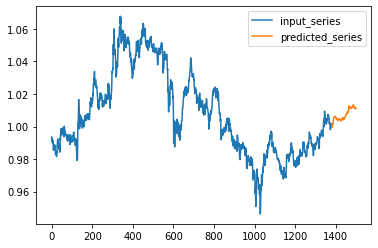

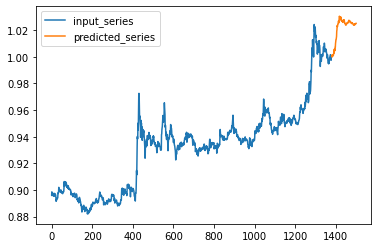

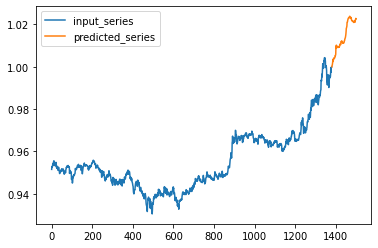

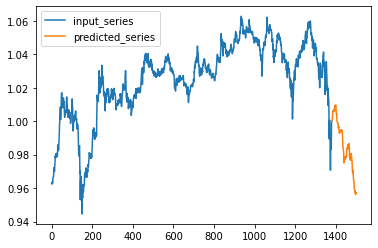

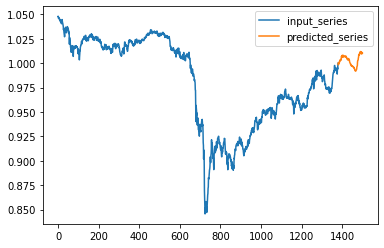

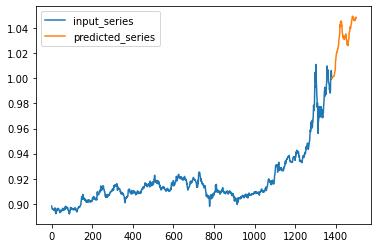

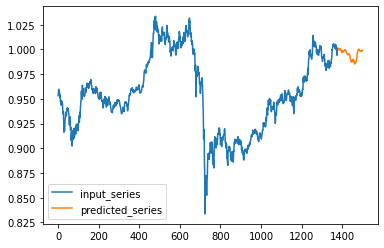

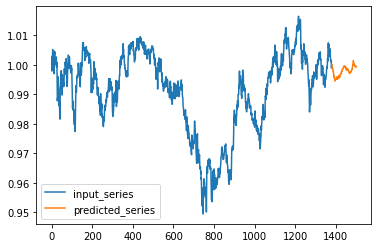

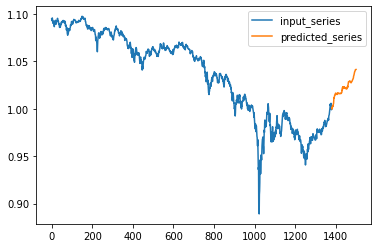

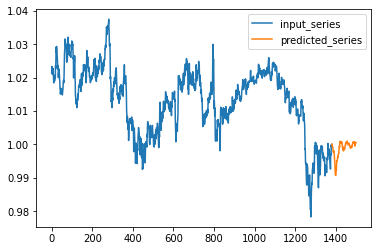

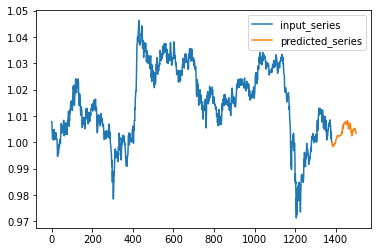

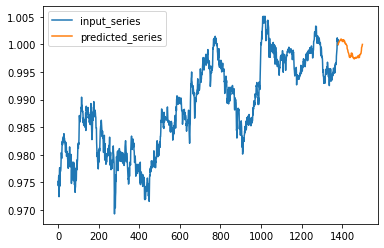

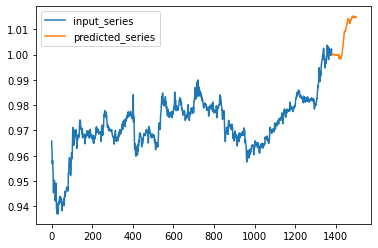

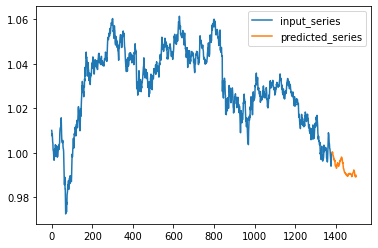

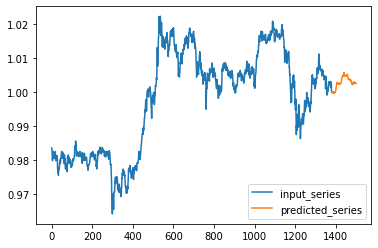

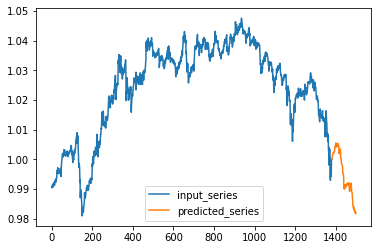

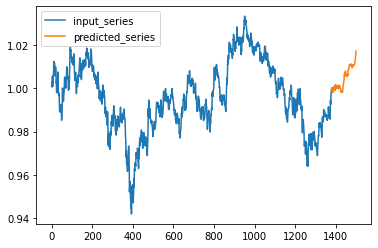

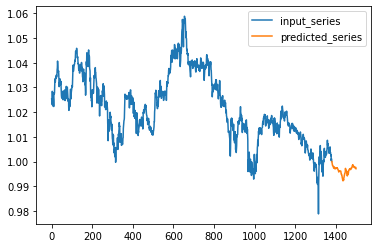

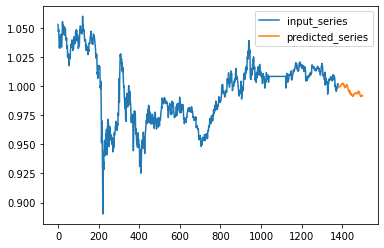

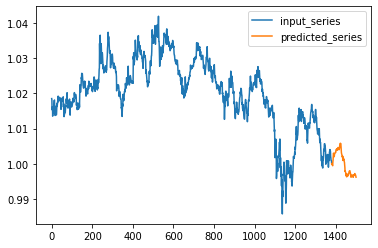

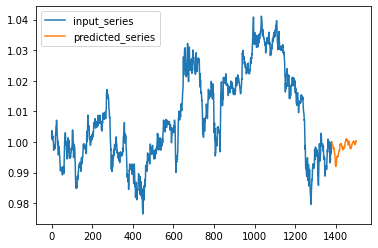

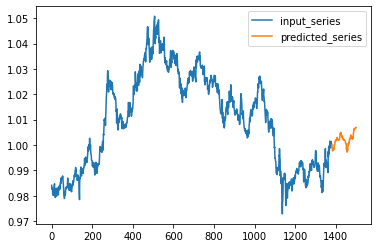

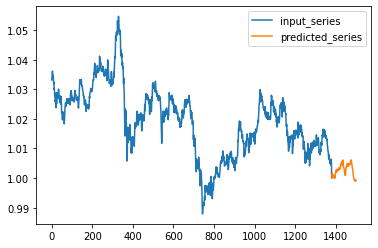

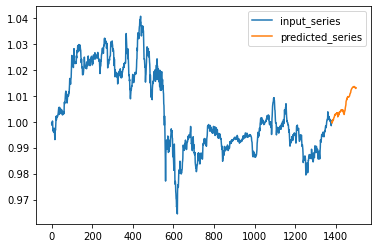

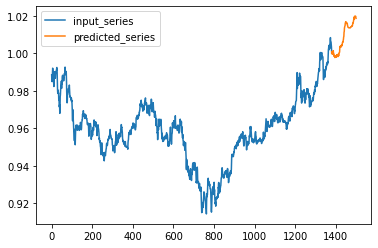

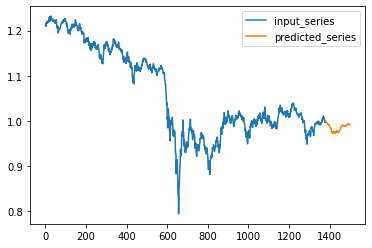

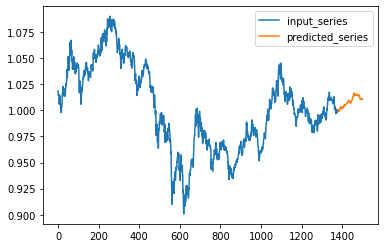

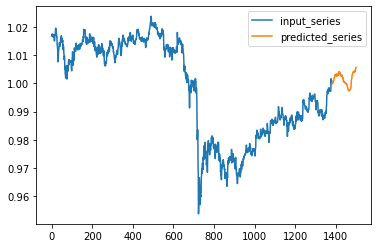

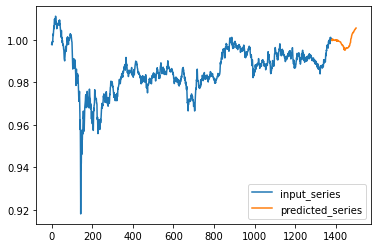

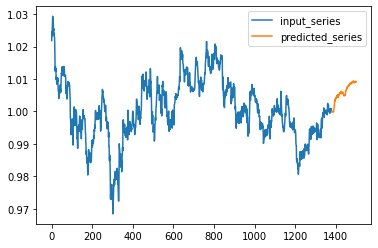

In [36]:
for i in range(30):  
    plt.plot() 
    plot_predicted_series(x_test_open[i,:], predicted[i,:]) 
    plt.show()

In [37]:
buy_quantities = [] 
sell_times = [] 

for i in tqdm(range(predicted.shape[0]), position = 0, leave = True): 
    sell_time = np.argmax(predicted[i,:]) 
    sell_times.append(sell_time) 
    buy_price = x_test_open[i,-1] 
    cnt = 0 
    for j in range(120): 
        if predicted[i,j] >= buy_price:    
            cnt += 1 
    buy_quantity = cnt/120 
    buy_quantities.append(buy_quantity)
    
submission.iloc[:,1] = buy_quantities 
submission.iloc[:,2] = sell_times  
submission.to_csv('gru_full_featurs.csv',index=False)


100%|██████████| 535/535 [00:00<00:00, 3924.74it/s]


In [38]:
submission

,sample_id,buy_quantity,sell_time
0,7661,0.991667,106
1,7662,1.000000,37
2,7663,1.000000,88
3,7664,0.208333,16
4,7665,0.683333,110
...,...,...,...
530,8191,0.008333,0
531,8192,0.033333,10
532,8193,0.975000,77
533,8194,0.008333,0
